<h1 style="color: #210e9c;">Pension Funds and reforms<br>OECD countries 2005-2020</h1>


**TF-IDF** stands for Term Frequency-Inverse Document Frequency. It’s a numerical statistic used to evaluate the importance of a word in a document relative to a collection (or corpus) of documents

# Step 1: Setup - Importing libraries

In [1]:
import pandas as pd
import numpy as np
import warnings

# 📊 Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px
from wordcloud import WordCloud

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier


# Text Processing (bag of words)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim.downloader as gensim_api 
import gensim 
from gensim.models import Word2Vec

# Pipeline & GridSearch
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/saraynes.gs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/saraynes.gs/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/saraynes.gs/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saraynes.gs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/saraynes.gs/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# ⚙️ Settings
pd.set_option('display.max_columns', None) # display all columns
warnings.filterwarnings('ignore') # ignore warnings

# Step 2: Loading the data set and Exploratory Data Analysis

## Loading the Data

In [3]:
df = pd.read_csv("../Data/data.csv", sep=";")

In [4]:
print(df.shape)
df.head()

(688, 9)


,Country,Year,Year-Country,Information type,OECD Private Pensions outlook,OECD Pensions @Glance,Text,Expanding measures,Contracting measures
0,Switzerland,1946.0,1946-Switzerland,Benefits,NaN,_,Federal Law of 20 December on old-age and surv...,1,NaN
1,Luxembourg,1967.0,1967-Luxembourg,Taxes,NaN,_,Article 111bis of the amended Law on Revenue T...,NaN,1.0
2,Germany,1974.0,1974-Germany,Coverage,NaN,_,The Gesetz zur Verbesserung der betrieblichen ...,1,NaN
3,Iceland,1974.0,1974-Iceland,Coverage,NaN,Base - Occupational mandatory_Overview,The mandatory pension fund system was introduc...,1,NaN
4,United States,1974.0,1974-United States,Coverage,NaN,NaN,The Employee Retirement Income Security Act (E...,1,NaN


### Best practices

#### Rename columns

In [5]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [6]:
df.head()

,country,year,year-country,information_type,oecd_private_pensions_outlook,oecd_pensions_@glance,text,expanding_measures,contracting_measures
0,Switzerland,1946.0,1946-Switzerland,Benefits,NaN,_,Federal Law of 20 December on old-age and surv...,1,NaN
1,Luxembourg,1967.0,1967-Luxembourg,Taxes,NaN,_,Article 111bis of the amended Law on Revenue T...,NaN,1.0
2,Germany,1974.0,1974-Germany,Coverage,NaN,_,The Gesetz zur Verbesserung der betrieblichen ...,1,NaN
3,Iceland,1974.0,1974-Iceland,Coverage,NaN,Base - Occupational mandatory_Overview,The mandatory pension fund system was introduc...,1,NaN
4,United States,1974.0,1974-United States,Coverage,NaN,NaN,The Employee Retirement Income Security Act (E...,1,NaN


#### Copy data

In [7]:
data = df.copy() # make a copy of the data   

#### NaN values

In [8]:
data.isnull().sum()

country                            0
year                             241
year-country                       0
information_type                 242
oecd_private_pensions_outlook    449
oecd_pensions_@glance            208
text                               0
expanding_measures               344
contracting_measures             568
dtype: int64

In [9]:
# "oecd_private_pensions_outlook", "oecd_pensions_@glance" columns describe the source of the data, not the data itself
data = data.drop(columns=["oecd_private_pensions_outlook", "oecd_pensions_@glance"])

In [10]:
# "expanding_measures" and "contracting_measures" took place 1 if there is a measure and 0 if there is no measure
data['expanding_measures'] = data['expanding_measures'].replace(np.nan, 0)
data['contracting_measures'] = data['contracting_measures'].replace(np.nan, 0)


In [11]:
# "year" does is empty when it collects descriptions of the pension system, not reforms
data.dropna(subset=['year', 'information_type'], inplace=True)

#### Duplicates, and empty spaces

In [12]:
data.duplicated().sum()

0

In [13]:
data.eq(" ").sum()

country                 0
year                    0
year-country            0
information_type        0
text                    0
expanding_measures      0
contracting_measures    0
dtype: int64

## Exploratory Data Analysis (EDA)

In [14]:
data.information_type[data.information_type=="Fee"] = "Fees"

1. Class distribution:

In [15]:
label_count = data["information_type"].value_counts().sort_index(ascending=False)
labels = label_count.index
sizes = label_count.values

information_type
Coverage                    111
Benefits                    100
Diversification/security     88
Contributions                77
Taxes                        51
Fees                         19
Name: count, dtype: int64


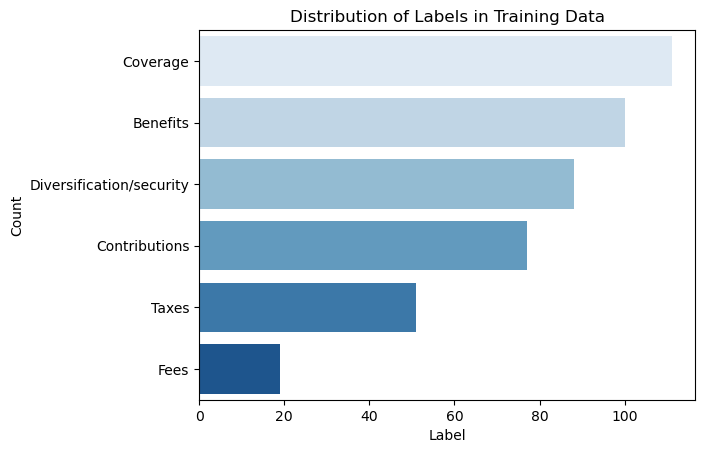

In [16]:
x = data['information_type'].value_counts()
print(x)
sns.barplot(x=x.values, y=x.index, palette='Blues')

# Adding labels and title for clarity
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in Training Data')
plt.show()

**Number of words in a text:**
The average number of words in coverage reforms is 53.76 as compared to an average of 31.58 words in fees reforms

In [17]:
#1.  WORD-COUNT
data['word_count'] = data['text'].apply(lambda x: len(str(x).split()))
print(data[data['information_type']=="Coverage"]['word_count'].mean()) 
print(data[data['information_type']=="Benefits"]['word_count'].mean()) 
print(data[data['information_type']=="Diversification/security"]['word_count'].mean()) 
print(data[data['information_type']=="Contributions"]['word_count'].mean()) 
print(data[data['information_type']=="Taxes"]['word_count'].mean()) 
print(data[data['information_type']=="Fees"]['word_count'].mean()) 

print("Coverage reforms are more wordy than the others, and Fees reforms are the least wordy")

#2. CHARACTER-COUNT
data['char_count'] = data['text'].apply(lambda x: len(str(x)))
print(data[data['information_type']=="Coverage"]['char_count'].mean())
print(data[data['information_type']=="Benefits"]['char_count'].mean())
print(data[data['information_type']=="Diversification/security"]['char_count'].mean())
print(data[data['information_type']=="Contributions"]['char_count'].mean())
print(data[data['information_type']=="Taxes"]['char_count'].mean())
print(data[data['information_type']=="Fees"]['char_count'].mean())

print("Coverage reforms are longer than the others, and Fees reforms are shorter")

#3. UNIQUE WORD-COUNT
data['unique_word_count'] = data['text'].apply(lambda x: len(set(str(x).split())))
print(data[data['information_type']=="Coverage"]['unique_word_count'].mean()) 
print(data[data['information_type']=="Benefits"]['unique_word_count'].mean()) 
print(data[data['information_type']=="Diversification/security"]['unique_word_count'].mean()) 
print(data[data['information_type']=="Contributions"]['unique_word_count'].mean()) 
print(data[data['information_type']=="Taxes"]['unique_word_count'].mean()) 
print(data[data['information_type']=="Fees"]['unique_word_count'].mean()) 
print("Coverage reforms have more unique words than the other groups, and Fees reforms have the least unique words")

53.765765765765764
49.84
46.67045454545455
50.77922077922078
38.450980392156865
31.57894736842105
Coverage reforms are more wordy than the others, and Fees reforms are the least wordy
350.1621621621622
308.17
316.375
310.90909090909093
242.6078431372549
206.31578947368422
Coverage reforms are longer than the others, and Fees reforms are shorter
40.288288288288285
37.23
35.06818181818182
36.05194805194805
30.372549019607842
26.473684210526315
Coverage reforms have more unique words than the other groups, and Fees reforms have the least unique words


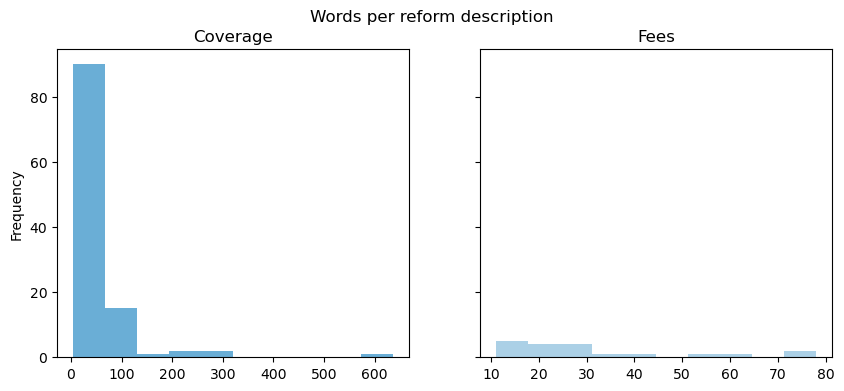

In [18]:
# Create a custom color palette using the 'Blues' palette from Seaborn
custom_colors = sns.color_palette("Blues", 5)

# Plotting word-count per news headline with a shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Use the same colors from the custom palette
# Assuming the colors you want to use are the first two in the custom_colors
train_words_fake = data[data['information_type'] == "Coverage"]['word_count']
ax1.hist(train_words_fake, color=custom_colors[2])  # Using another shade
ax1.set_title('Coverage')

train_words_real = data[data['information_type'] == "Fees"]['word_count']
ax2.hist(train_words_real, color=custom_colors[1])  # Using a specific shade of blue
ax2.set_title('Fees')

# Common y-axis label
ax1.set_ylabel('Frequency')

fig.suptitle('Words per reform description')

plt.show()

# Step 3: Text Pre-Processing

In [19]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() #lowercase text 
    text = text.strip() #get rid of leading/trailing whitespaces 
    text = re.compile('<.*?>').sub('', text) #remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip()) #Remove not alphanumeric symbols white spaces
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

# STEMMING
# Initialize the stemmer
snow = SnowballStemmer('english')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string)]
    return " ".join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
# Full list is available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

Final pre-processing

In [20]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

data['clean_text'] = data['text'].apply(lambda x: finalpreprocess(x))
data = data.drop(columns=['word_count', 'char_count', 'unique_word_count'])
data.head()

,country,year,year-country,information_type,text,expanding_measures,contracting_measures,clean_text
0,Switzerland,1946.0,1946-Switzerland,Benefits,Federal Law of 20 December on old-age and surv...,1,0.0,federal law december old age survivor insurance
1,Luxembourg,1967.0,1967-Luxembourg,Taxes,Article 111bis of the amended Law on Revenue T...,0,1.0,article bi amend law revenue taxation concern ...
2,Germany,1974.0,1974-Germany,Coverage,The Gesetz zur Verbesserung der betrieblichen ...,1,0.0,gesetz zur verbesserung der betrieblichen alte...
3,Iceland,1974.0,1974-Iceland,Coverage,The mandatory pension fund system was introduc...,1,0.0,mandatory pension fund system introduce self e...
4,United States,1974.0,1974-United States,Coverage,The Employee Retirement Income Security Act (E...,1,0.0,employee retirement income security act erisa ...


## Word2Vec Model

In [21]:
# create Word2vec model
#here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#length of words_f is number of documents/sentences in your dataset

# Extracting the Word2Vec dictionary from the model
data['clean_text_tok']=[nltk.word_tokenize(i) for i in data['clean_text']] #convert preprocessed sentence to tokenized sentence

# Building the Word2Vec model
model = Word2Vec(data['clean_text_tok'],min_count=1) #min_count=1 means word should be present at least across all documents,    
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it

# Use model.wv.index_to_key instead of model.wv.index2word
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors)) #combination of word and its vector


In [22]:
#building Word2Vec model
class MeanEmbeddingVectorizer(object):
        def __init__(self, word2vec):
                self.word2vec = word2vec
                # if a text is empty we should return a vector of zeros
                # with the same dimensionality as all the other vectors
                self.dim = len(next(iter(word2vec.values())))

        def fit(self, X, y):
                return self
        
        def transform(self, X):
                return np.array([
                        np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0)
                        for words in X
                ])

# Step 4: Extracting vectors from text (Vectorization)

In [23]:
data['information_type'] = data['information_type'].map({'Coverage': 1, 'Benefits': 2, 'Diversification/security': 3, 'Contributions': 4, 'Taxes': 5, 'Fees': 6})

In [24]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(data["clean_text"],
                                                    data["information_type"],
                                                    test_size=0.2,
                                                    shuffle=True)

In [25]:
#Word2Vec
# Word2Vec runs on tokenized sentences
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

Bag-of-Words (with TF-IDF ) and Word2Vec

In [26]:
#for word embedding
import gensim.downloader as gensim_api 
import gensim 
from gensim.models import Word2Vec

In [27]:
#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec

# Only transform x_test (not fit and transform)
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test) 
#Don't fit() your TfidfVectorizer to your test data: it will change the word-indexes & weights to match test data. 
# Rather, fit on the training data, then use the same train-data-fit model on the test data, 
# to reflect the fact you're analyzing the test data only based on what was learned without 
# it, and the have compatible array shapes

In [28]:
# Using MeanEmbeddingVectorizer
modelw = MeanEmbeddingVectorizer(w2v)

# Convert to vectors
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_test_vectors_w2v = modelw.transform(X_test_tok)

# Step 5. Running ML algorithms

## 1. Logistic regression (tf-idf)

In [29]:
#Fitting the classification model using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

print("Classification Report")
print(classification_report(y_test,y_predict))

print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

Classification Report
              precision    recall  f1-score   support

           1       0.68      0.64      0.66        33
           2       0.47      0.57      0.52        14
           3       0.40      0.47      0.43        17
           4       0.64      0.69      0.67        13
           5       0.83      0.56      0.67         9
           6       1.00      0.50      0.67         4

    accuracy                           0.59        90
   macro avg       0.67      0.57      0.60        90
weighted avg       0.62      0.59      0.60        90

Confusion Matrix: [[21  3  8  1  0  0]
 [ 1  8  1  3  1  0]
 [ 6  2  8  1  0  0]
 [ 1  2  1  9  0  0]
 [ 2  2  0  0  5  0]
 [ 0  0  2  0  0  2]]


In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

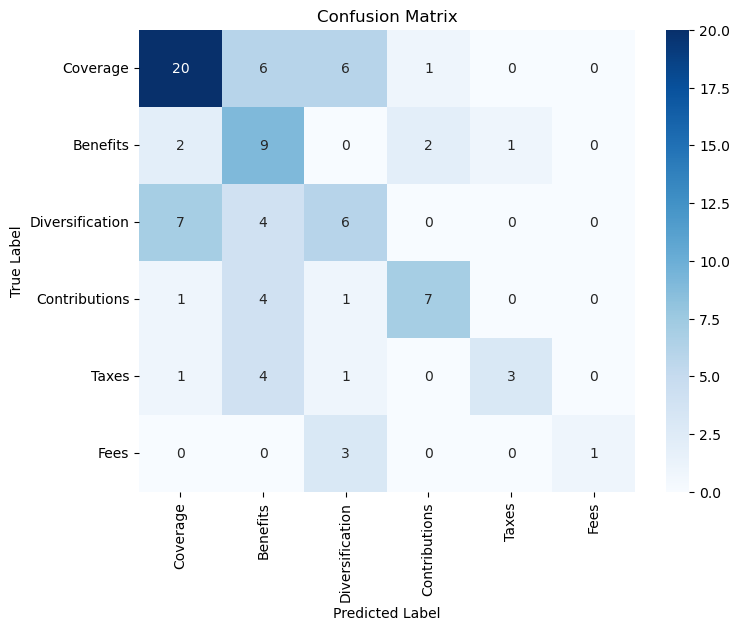

In [41]:
class_names = ['Coverage','Benefits', 'Diversification', 'Contributions', 'Taxes', 'Fees']
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)

# Plot confusion matrix with Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## 2. Naive Bayes (tf-idf)

In [32]:
#Fitting the classification model using Naive Bayes(tf-idf)
# ==============================================
#It's a probabilistic classifier that makes use of Bayes' Theorem, 
# a rule that uses probability to make predictions based on 
# prior knowledge of conditions that might be related. 
# This algorithm is the most suitable for such large dataset as 
# it considers each feature independently, 
# calculates the probability of each category, 
# and then predicts the category with the highest probability.

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

           1       0.67      0.67      0.67        33
           2       0.39      0.86      0.53        14
           3       0.44      0.41      0.42        17
           4       0.78      0.54      0.64        13
           5       1.00      0.11      0.20         9
           6       0.00      0.00      0.00         4

    accuracy                           0.54        90
   macro avg       0.54      0.43      0.41        90
weighted avg       0.60      0.54      0.52        90

Confusion Matrix: [[22  8  3  0  0  0]
 [ 1 12  1  0  0  0]
 [ 6  3  7  1  0  0]
 [ 1  4  1  7  0  0]
 [ 3  4  0  1  1  0]
 [ 0  0  4  0  0  0]]


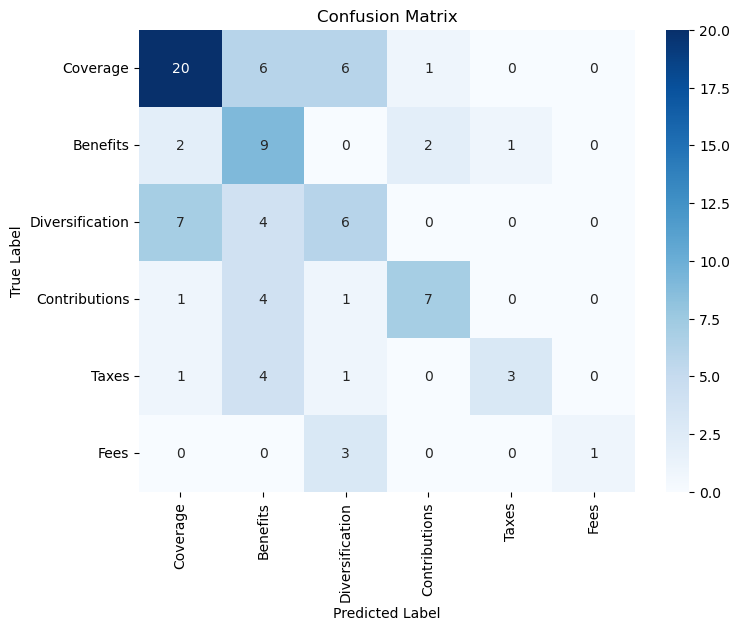

In [42]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)

# Plot confusion matrix with Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## 3.LR (w2v)

In [34]:
#Fitting the classification model using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_test_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_test_vectors_w2v)[:,1]
 

print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        33
           2       0.20      0.64      0.31        14
           3       0.21      0.41      0.27        17
           4       0.33      0.31      0.32        13
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00         4

    accuracy                           0.22        90
   macro avg       0.12      0.23      0.15        90
weighted avg       0.12      0.22      0.15        90

Confusion Matrix: [[ 0 16 14  3  0  0]
 [ 0  9  4  1  0  0]
 [ 0  9  7  1  0  0]
 [ 0  5  4  4  0  0]
 [ 0  4  2  3  0  0]
 [ 0  1  3  0  0  0]]


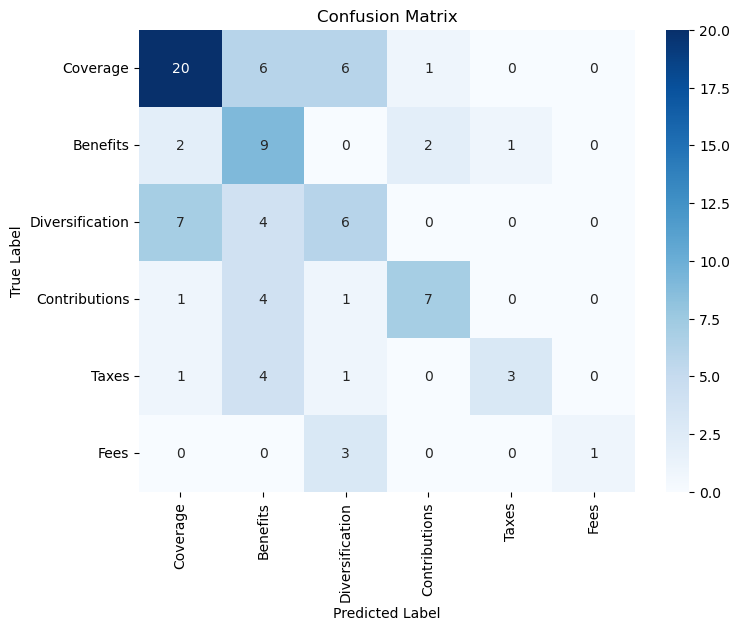

In [43]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)

# Plot confusion matrix with Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## 4. RandomForest

In [36]:
from sklearn.model_selection import cross_val_score # K-Folds cross validation

In [37]:
# Implement RandomForest Classifier with additional parameters
randomclassifier = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=10, random_state=42)

# n_estimators: number of trees in the forest
# criterion: function to measure the quality of a split. Entropy is the measure of impurity
# max_depth: maximum depth of the tree
# random_state: seed for random number generator

In [38]:
# Fit the model on the training data
randomclassifier.fit(X_train_vectors_tfidf, y_train)

# Predict y values for the test dataset
y_predict = randomclassifier.predict(X_test_vectors_tfidf)
y_prob = randomclassifier.predict_proba(X_test_vectors_tfidf)[:, 1]

# Print classification report and confusion matrix
print(classification_report(y_test, y_predict))
print('Confusion Matrix:', confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

           1       0.65      0.61      0.62        33
           2       0.33      0.64      0.44        14
           3       0.35      0.35      0.35        17
           4       0.70      0.54      0.61        13
           5       0.75      0.33      0.46         9
           6       1.00      0.25      0.40         4

    accuracy                           0.51        90
   macro avg       0.63      0.45      0.48        90
weighted avg       0.58      0.51      0.52        90

Confusion Matrix: [[20  6  6  1  0  0]
 [ 2  9  0  2  1  0]
 [ 7  4  6  0  0  0]
 [ 1  4  1  7  0  0]
 [ 1  4  1  0  3  0]
 [ 0  0  3  0  0  1]]


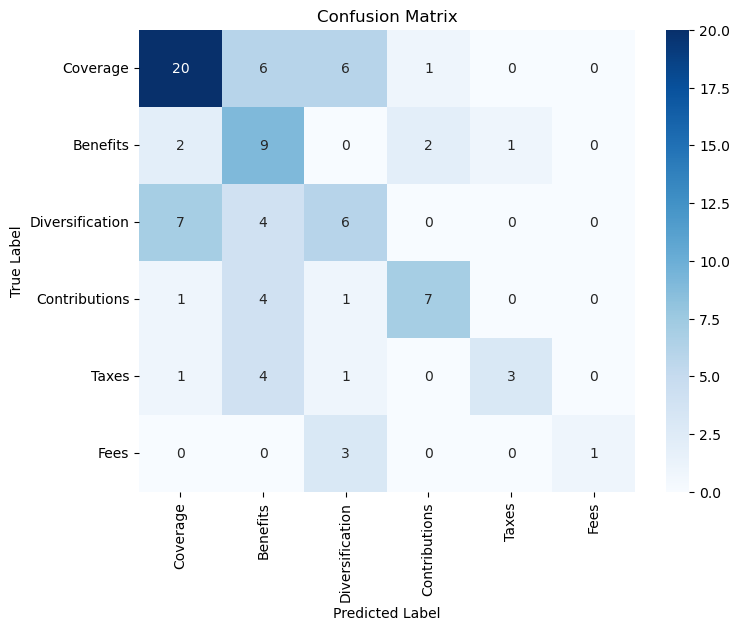

In [44]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)

# Plot confusion matrix with Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Cross-Validation

In [40]:
# Perform cross-validation
# cv=5 denotes using 5 folds
cv_scores = cross_val_score(randomclassifier, X_train_vectors_tfidf, y_train, cv=5, scoring='accuracy')

# Print out the cross-validation scores and the mean score
print("Cross-validation scores for each fold:", cv_scores)
print("Mean cross-validation accuracy:", np.mean(cv_scores))

Cross-validation scores for each fold: [0.55555556 0.56338028 0.56338028 0.73239437 0.63380282]
Mean cross-validation accuracy: 0.6097026604068858
